In [7]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [8]:
import pickle
import json

In [9]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [10]:
from nltk import ngrams

In [11]:
def single_amplify(to_amplify, population=None, v = False):
    if population is None:
        population = [x for x in to_amplify]
    
    new = []
    for chain in to_amplify:
        start = np.random.randint(0, len(chain) - 1)
        stop = False
        end = np.random.randint(start + 1, len(chain))
        
        new_chain = []
        pointer = start
        
        while not stop:
            switch = np.random.rand() < SWITCH_PROB
            
            if v:
                print(chain, new_chain, switch)
            if switch:
                chain = population[np.random.randint(0, len(population))]
                pointer = np.random.randint(0, len(chain))

            if np.random.rand() < STOP_PROB:
                stop = True
            
            if len(new_chain) >= end - start:
                stop = True
                
            if pointer < len(chain):
                new_chain.append(chain[pointer])
            else:
                stop = True
                
            pointer += 1 
    
        if len(new_chain) > 1:
            new.append(new_chain)
    
    return [x[::-1] for x in new]

In [12]:
def PCR_cycle(population_f, population_b):
    mask_f = np.random.binomial(1, AMPLIFY_PROB, len(population_f))
    mask_b = np.random.binomial(1, AMPLIFY_PROB, len(population_b))
    
    to_amp_f = np.array(population_f)[mask_f.astype(bool)]
    to_amp_b = np.array(population_b)[mask_b.astype(bool)]
    
    new_f = single_amplify(to_amp_b, population_b)
    new_b = single_amplify(to_amp_f, population_f)
    
    population_f.extend([x for x in new_f if len(x) > 1])
    population_b.extend([x for x in new_b if len(x) > 1])

#    new_f = [x[::-1] for x in single_amplify(to_amp_f, population_f)]
#    population_f.extend([x for x in new_f if len(x) > 1])
            
    #population.extend([x for x in new if len(x) > 1])

In [23]:
def generate_elka_graph(spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num):
        for j in range(spacers_num -1, i, -1):
            graph[i,j] = spacers_num - j
    return graph

def generate_shift_diag_graph(spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    for i in range(spacers_num -1):
        graph[i, i + 1] = 1
    return graph

In [59]:
def generate_initial_population(graph, chain_number=2, max_amount_per_chain = 2, min_len = 4, max_len = 10, v = False):
    # markov is our god! 
    spacers_num = graph.shape[0]
   

    if v:
        plot_gr(graph)
        
    graph /= np.max(np.vstack((graph.sum(1), np.ones(spacers_num))), 0).reshape(-1,1)
    all_chains = []
    while len(all_chains) < chain_number:
        chain = []
        amount = np.random.randint(1, max_amount_per_chain)
        max_chain_len = max([np.random.randint(min_len, max_len) for i in range(3)])
        curr = np.random.randint(0, (spacers_num - 1) / 2 )

        for j in range(max_chain_len):
            chain.append(curr)
            if curr != spacers_num - 1:
                #print(np.arange(spacers_num), graph[curr])
                curr = np.random.choice(np.arange(spacers_num), 1, p = graph[curr])[0]
            else:
                break
        
        if len(chain) > min_len:
            all_chains.extend([chain for k in range(amount)])
    
    return all_chains[:chain_number]

In [16]:
SWITCH_PROB = 0.01
AMPLIFY_PROB = 0.35
STOP_PROB = 0

In [17]:
all_ratios_plots = []

In [18]:
population_f = [[0,1,2,3,4,5] for i in range(5)] + [[0,6,7,8,9, 10]]
population_b = [x[::-1] for x in population_f]


pairs_1 = [x for x in ngrams([0,1,2,3,4,5], 2)]
pairs_2 = [x for x in ngrams([0,6,7,8,9], 2)]

In [19]:
def amp_population(population, spacers_num, max_chains = 25000, max_epochs = 15):
    population_f = [x for x in population]
    population_b = [x[::-1] for x in population_f]

    epoch = 0
    
    while (len(population_f) + len(population_b) < max_chains) and epoch < max_epochs:
        PCR_cycle(population_f, population_b)
        epoch += 1
    
    full_population_amplified = population_f + [x[::-1] for x in population_b]
    
    all_pairs = []
    for seq in full_population_amplified:
        for x in ngrams(seq,2):
            all_pairs.append(x)

    graph = np.zeros((spacers_num, spacers_num))
    for p in all_pairs:
        graph[p[0],p[1]] += 1
        
    return graph

In [20]:
def reshuffle(population, spacers_num):
    spacers_shuffled = np.arange(spacers_num)
    np.random.shuffle(spacers_shuffled)
    shuffle_map = dict(zip(np.arange(spacers_num), spacers_shuffled))
    
    return [[shuffle_map[x] for x in y] for y in population]

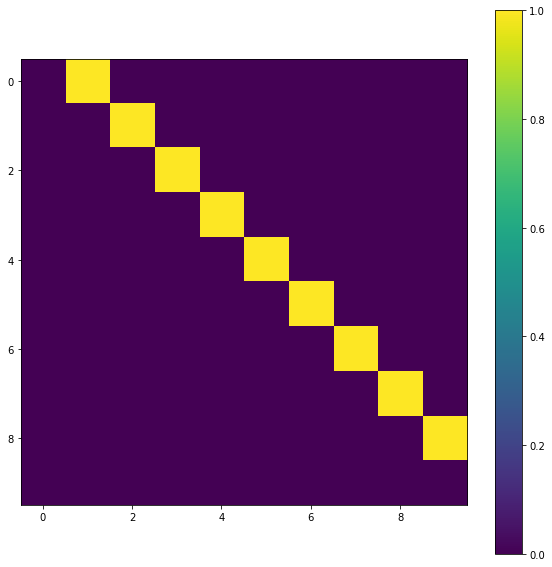

[[1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6],
 [2, 3, 4, 5, 6, 7, 8, 9]]

In [24]:
pp = generate_initial_population(generate_shift_diag_graph(10), 6, 10, v =1)
pp

In [33]:
gr = amp_population(pp, 10, max_epochs=30)

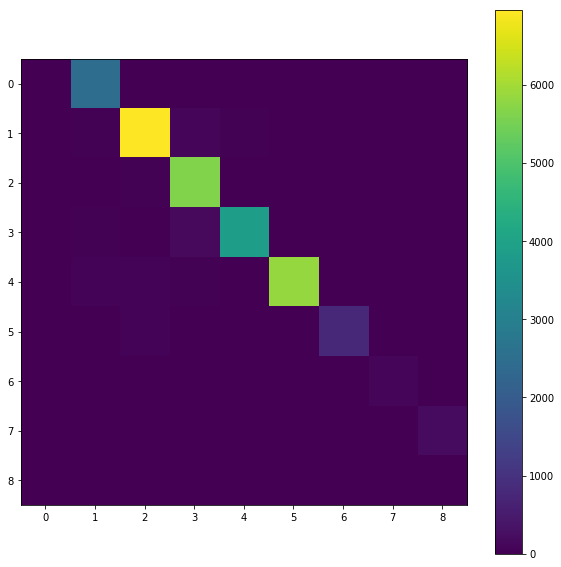

In [34]:
plot_gr(gr, 1)

In [35]:
def population_to_gr(population, spacers_num):
    graph = np.zeros((spacers_num, spacers_num))
    
    for chain in population:
        for p in ngrams(chain, 2):
            graph[p[0], p[1]] = 1
    
    return graph

In [36]:
def complete_population(population, shape):
    answ = np.ones(shape) * -1
    
    for i, chain in enumerate(population):
        answ[i, :len(chain)] = np.array(chain)
    return answ

In [76]:
params = {"N_POPULATONS" : 10000,
            "N_SPACERS" : 50,
            "N_CHAINS" : 12,
            "MAX_LEN" : 13,
            "SWITCH_PROB" : 0.05,
            "AMPLIFY_PROB"  :0.35,
            "STOP_PROB" : 0,
            "MAX_POPULATION_SIZE" : 10000}

SWITCH_PROB = params["SWITCH_PROB"]
AMPLIFY_PROB = params["AMPLIFY_PROB"]
STOP_PROB = params["STOP_PROB"]

synthetic_populations = np.zeros((params["N_POPULATONS"], params["N_CHAINS"], params["MAX_LEN"]))
amp_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))
initial_graphs = np.zeros((params["N_POPULATONS"], params["N_SPACERS"], params["N_SPACERS"]))


for i in tqdm_notebook(range(params["N_POPULATONS"])):
    p = generate_initial_population(generate_shift_diag_graph(params["N_SPACERS"]),
                                    params["N_CHAINS"],
                                    10,
                                    max_len=params["MAX_LEN"])
    p = reshuffle(p, params["N_SPACERS"])
    synthetic_populations[i] = complete_population(p, (params["N_CHAINS"], params["MAX_LEN"] ))

    amp_graphs[i] = amp_population(p, params["N_SPACERS"], params["MAX_POPULATION_SIZE"], 20)
    initial_graphs[i] = population_to_gr(p, params["N_SPACERS"])

A Jupyter Widget

In [77]:
np.save("../../data/simulation/50sp_10k/populations", synthetic_populations)
np.save("../../data/simulation/50sp_10k/populations_gr", initial_graphs)
np.save("../../data/simulation/50sp_10k/amp_gr", amp_graphs)
json.dump(params, open("../../data/simulation/50sp_10k/params.json", 'w'))

# INV

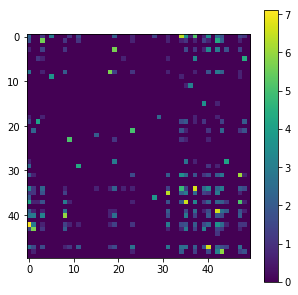

In [83]:
plot_gr(amp_graphs[0], s = 5, log = 1)

A Jupyter Widget

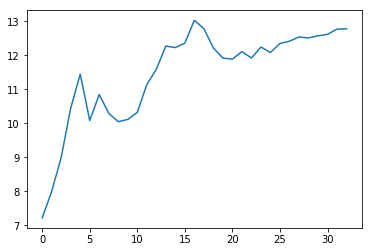

In [54]:
population_ratio = []

for i in tqdm_notebook(range(35)) :
    PCR_cycle(population_f, population_b)
    
    all_pairs = []
    for seq in population_f + [x[::-1] for x in population_b]:
        for x in ngrams(seq,2):
            all_pairs.append(x)
            
    cp_1, cp_2, cp_3 = 0,0,0
    for p in all_pairs:
        if p in pairs_1:
            cp_1+=1
        elif p in pairs_2:
            cp_2+=1
        else:
            cp_3+=1
            
#     c_1, c_2, c_3 = 0,0,0
#     for p in population_f:
#         for l in p:
#             if l in [0,1,2,3,4,5]:
#                 c_1+=1
#             elif l in [6,7,8,9]:
#                 c_2+=1
#             else:
#                 c_3+=1
    #print(len(population_f), c_1, c_2, c_3, c_1 / c_2)
    population_ratio.append(cp_1 / cp_2)
    
    #print(len(population_f))#, len(population_b))
    if len(population_f) >100000:
        break

all_ratios_plots.append(population_ratio)


for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()



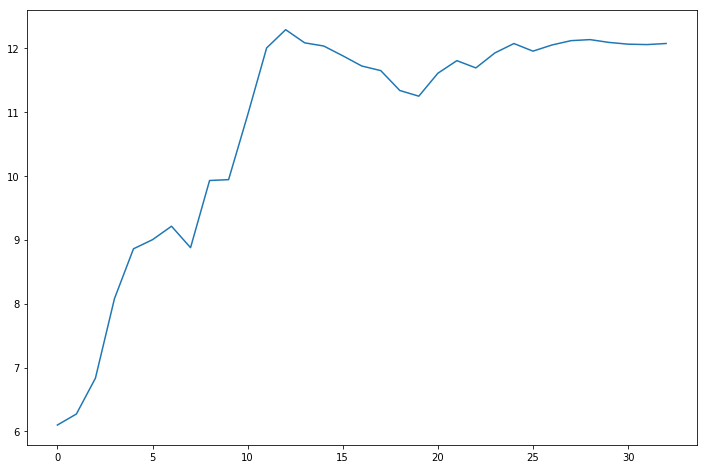

In [266]:
plt.figure(figsize=(12,8))

for p_r in all_ratios_plots:
    plt.plot(p_r)
plt.show()


In [167]:
c_1 / c_2

15.804110043089162

In [267]:
population = population_f + [x[::-1] for x in population_b]

In [134]:
all_pairs = []
for seq in population:
    for x in ngrams(seq,2):
        all_pairs.append(x)
len(all_pairs)

33222

In [268]:
graph = np.zeros((11,11))

for p in all_pairs:
    graph[p[0],p[1]] += 1

In [269]:
c_1, c_2, c_3 = 0,0,0
for p in all_pairs:
    if p in pairs_1:
        c_1+=1
    elif p in pairs_2:
        c_2+=1
    else:
        c_3+=1

In [270]:
print(c_1, c_2, c_3, c_1 / c_2)

224870 18631 22514 12.069668831517363


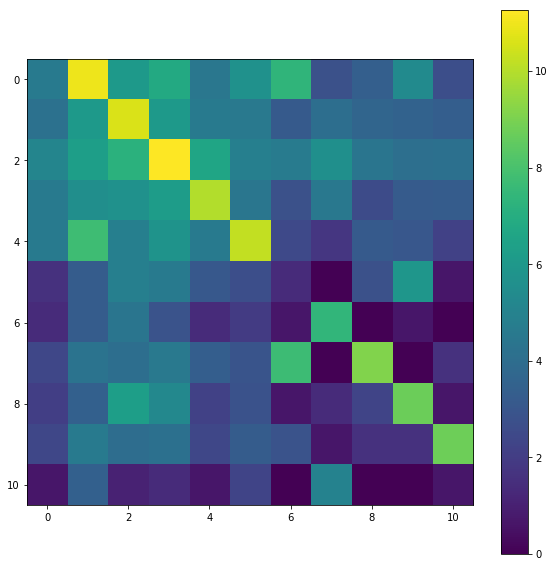

In [271]:
plot_gr(graph, log = 1)

In [589]:
c_2

3162

In [336]:
c_3

18988

In [480]:
pairs_1

<generator object ngrams at 0x7f7b6a570e60>

In [479]:
all_pairs[:30]

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 0),
 (0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (0, 6)]

In [283]:
ES3_b

[[16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [16, 12, 17, 15, 14, 13, 10, 9, 8, 6, 3, 0, 1],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [11, 7, 5, 2, 4],
 [34, 33, 32, 31, 28, 26, 27, 30, 25, 18, 19, 24],
 [29, 21, 23, 22, 20],
 [17, 15, 14],
 [13, 10, 9],
 [6, 3, 0],
 [11, 7],
 [7, 5, 2],
 [11, 7, 5, 2],
 [11, 7, 5, 2, 4],
 [32, 31],
 [29, 21],
 [16, 12, 17, 15, 14],
 [16, 12, 17, 15],
 [8, 6],
 [10, 9],
 [11, 7, 5, 2],
 [11, 7],
 [11, 7],
 [7, 5, 2],
 [12, 17, 15, 14],
 [14, 17, 15],
 [2, 4],
 [28, 26, 27, 30],
 [22, 20],
 [12, 17, 15],
 [16, 12],
 [12, 17],
 [6, 3],
 [11, 7, 5, 2],
 [11, 7, 5],
 [11, 7, 5, 2],
 [34, 33, 32, 31, 28, 26, 27, 30],
 [29, 21],
 [12, 17],
 [17, 15],
 [28, 26, 27, 30],
 [0, 1],
 [0, 1],
 [5, 2, 4],
 [5, 2, 4],
 [23, 22],
 [3, 0],
 [11, 7],
 [16, 12, 17, 15, 14, 13, 10, 9, 8

In [284]:
ES3_f

[[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [4, 2, 5, 7, 11],
 [24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34],
 [20, 22, 23, 21, 29],
 [13, 14, 15, 17, 12],
 [13, 14, 15, 17, 14],
 [1, 0, 3],
 [4, 2],
 [4, 2, 5],
 [5, 7, 11],
 [25, 30, 27, 26, 28],
 [20, 22],
 [1, 0],
 [1, 0, 3, 6, 8, 9, 10, 13],
 [1, 0],
 [1, 0],
 [4, 2, 5, 7],
 [4, 2, 5, 7],
 [4, 2, 5],
 [18, 25],
 [22, 23],
 [0, 3],
 [7, 11],
 [5, 7],
 [2, 5],
 [1, 15],
 [6, 8, 9, 10, 13],
 [3, 6],
 [1, 0, 3, 6, 8, 9],
 [1, 0, 3, 6],
 [4, 2, 5],
 [4, 2, 5, 7],
 [4, 2],
 [19, 18, 25, 30, 27],
 [22, 23],
 [14, 15, 17],
 [0, 3],
 [2, 5],
 [4, 2],
 [9, 10],
 [7, 11],
 [2, 5, 7],
 [4, 2],
 [30, 27],
 [20, 22],
 [1, 0],
 [3, 6],
 [4, 2, 5],
 [4, 2],
 [19, 18],
 [1

In [53]:
population=reshuffle(population, np.arange(10))

In [272]:
m = np.ones((3,3))

In [365]:
pp = generate_initial_population(5, 6, 5)
ppr = reshuffle(pp,5)
print(pp)
print(ppr)

[[0.         0.25       0.25       0.25       0.25      ]
 [0.         0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         0.5        0.5       ]
 [0.         0.         0.         0.         1.        ]
 [0.         0.         0.         0.         0.        ]]
5
5
4
[[0, 3, 4], [0, 3, 4], [1, 3, 4], [1, 3, 4], [0, 1, 3, 4], [0, 1, 3, 4]]
[[3, 1, 4], [3, 1, 4], [2, 1, 4], [2, 1, 4], [3, 2, 1, 4], [3, 2, 1, 4]]


In [684]:
population_f = [[1, 0, 3, 6, 8, 9, 10, 13, 14, 15, 17, 12, 16] for i in range(5)] + \
        [[4, 2, 5, 7, 11] for i in range(5)] + \
        [[24, 19, 18, 25, 30, 27, 26, 28, 31, 32, 33, 34]] + \
        [[20, 22, 23, 21, 29]]
        
population_b = [x[::-1] for x in population_f]